# MRMS Precipitation Plots
By: Ty Janoski

## Setup

In [1]:
# import statements

import gzip
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import gzip
from io import BytesIO
import xarray as xr
import tempfile
import os


In [10]:
# Make the above code into a function
def read_in_mrms_data(bucket_name: str, path: str, hour: str) -> xr.DataArray:
    # Set up S3 client
    s3 = boto3.client(
        "s3", region_name="us-east-1", config=Config(signature_version=UNSIGNED)
    )

    # List objects from AWS Bucket
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=path)

    # Find key containing hour.grib2.gz, which is the file we want
    for obj in response["Contents"]:
        if f"{hour}.grib2.gz" in obj["Key"]:
            key = obj["Key"]
            break

    # Read in the file
    grib_data = BytesIO()
    s3.download_fileobj(bucket_name, key, grib_data)
    grib_data.seek(0)

    with tempfile.NamedTemporaryFile(suffix=".grib2", delete=False) as tmp_file:
        with gzip.open(grib_data, "rb") as f:
            tmp_file.write(f.read())
        tmp_file_path = tmp_file.name

        
        da = xr.open_dataarray(tmp_file_path, engine="cfgrib")

    return da
    

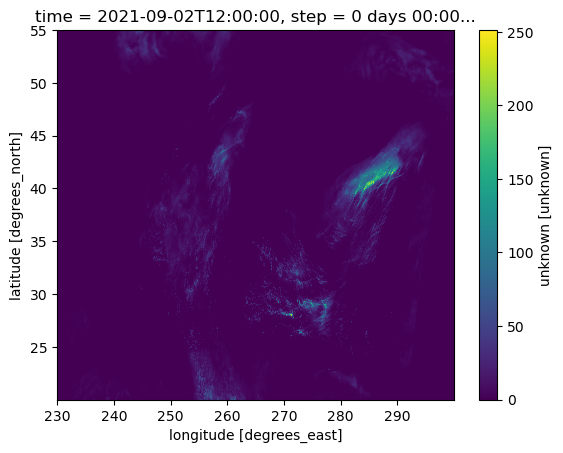

In [12]:
# Bucket name
bucket_name = "noaa-mrms-pds"

read_in_mrms_data(
    bucket_name, "CONUS/MultiSensor_QPE_24H_Pass2_00.00/20210902/", "120000"
).plot()
